In [80]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import vlc

In [238]:
train = pd.read_csv('data/en/train.tsv', sep='\t')
train = train[['client_id', 'path', 'age', 'gender', 'sentence']].dropna()
train = train[train['gender'] != 'other']

In [239]:
print(train.shape[0]/train['client_id'].nunique())
print()

46.87558139534884



In [240]:
train.columns

Index(['client_id', 'path', 'age', 'gender', 'sentence'], dtype='object')

In [241]:
def show_and_play(case_num):
    
    def power_to_db(S, amin=1e-16, top_db=80.0):   
        #Based on:
        #https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html    
        def _tf_log10(x):
            numerator = tf.math.log(x)
            denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
            return numerator / denominator
        
        # Scale magnitude relative to maximum value in S. Zeros in the output 
        # correspond to positions where S == ref.
        ref = tf.reduce_max(S)

        log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
        log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

        log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

        return log_spec
    path = str('data/en/clips/' + train['path'].iloc[case_num])
    audio_binary = tf.io.read_file(path)
    audio = tfio.audio.decode_mp3(audio_binary)
    audiofft = tf.signal.stft( tf.squeeze(audio), frame_length=1024, frame_step=512 )
    fftabs = tf.transpose(tf.math.abs(audiofft))
    log_fft = power_to_db(fftabs)

    fig, ax = plt.subplots(figsize=(16, 5))
    ax.imshow(log_fft, cmap='plasma', interpolation='nearest', aspect='auto')
    plt.gca().invert_yaxis()
    print('Recording:\t', case_num, '/', train.shape[0]-1)
    print('Client ID:\t', train['client_id'].iloc[case_num])
    print('Sentence:\t', train['sentence'].iloc[case_num])
    print('Age:\t\t', train['age'].iloc[case_num])
    print('Gender:\t\t', train['gender'].iloc[case_num])

    p = vlc.MediaPlayer(path)
    p.play()

Recording:	 35703 / 322503
Client ID:	 cd3ece2da6b3728fa3405a444cea30e4fcafff7006718d034f74353b6fc0d1686aee50e9a0d690e45b642490d4ea34f08cd8bc7e814729fddb6e71b2ce766432
Sentence:	 The civilization cards grant access to abilities such as agriculture, coinage, philosophy and medicine.
Age:		 twenties
Gender:		 male


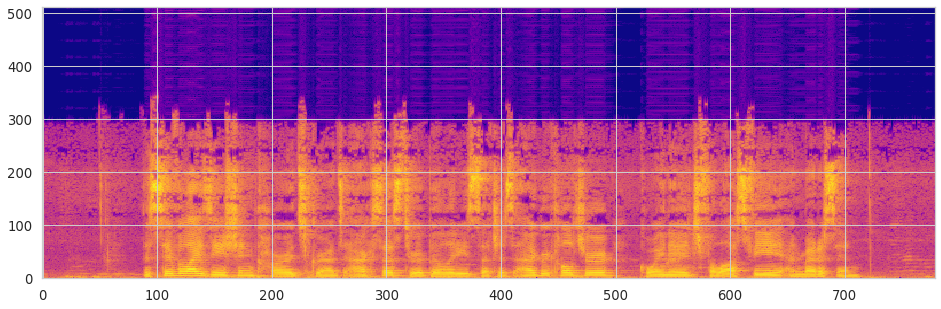

In [242]:
show_and_play(35703)

In [243]:
(train['age'].value_counts()/(train['age'].shape[0]+1))*100

twenties     37.374304
thirties     19.623882
fourties     16.929040
sixties      10.913939
fifties       7.173222
teens         6.681757
seventies     1.152540
eighties      0.134572
nineties      0.016434
Name: age, dtype: float64

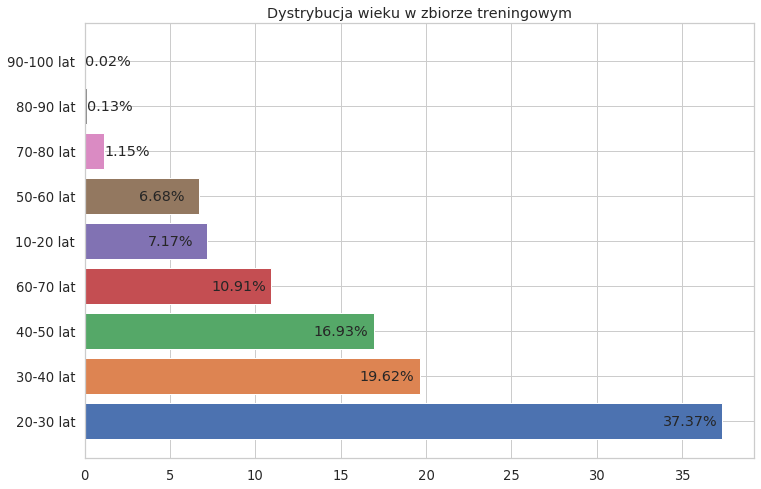

In [245]:
import seaborn as sns
sns.set(font_scale=1.2, style='whitegrid')
colors = sns.color_palette()

labels = ['20-30 lat', '30-40 lat', '40-50 lat', '60-70 lat', '10-20 lat', '50-60 lat', '70-80 lat', '80-90 lat', '90-100 lat']
values = (train['age'].value_counts()/(train['age'].shape[0]+1))*100

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(
    labels,
    values,
    color=(colors[0], colors[1], colors[2], colors[3], colors[4], colors[5], colors[6], colors[7], colors[8])
    )
ax.set(title='Dystrybucja wieku w zbiorze treningowym')
for index, value in enumerate(values):
    if value>5:
        ax.text(value-3.5, index-0.1, str(np.round(value, 2))+'%')
    else:
        ax.text(value, index-0.1, str(np.round(value, 2))+'%')

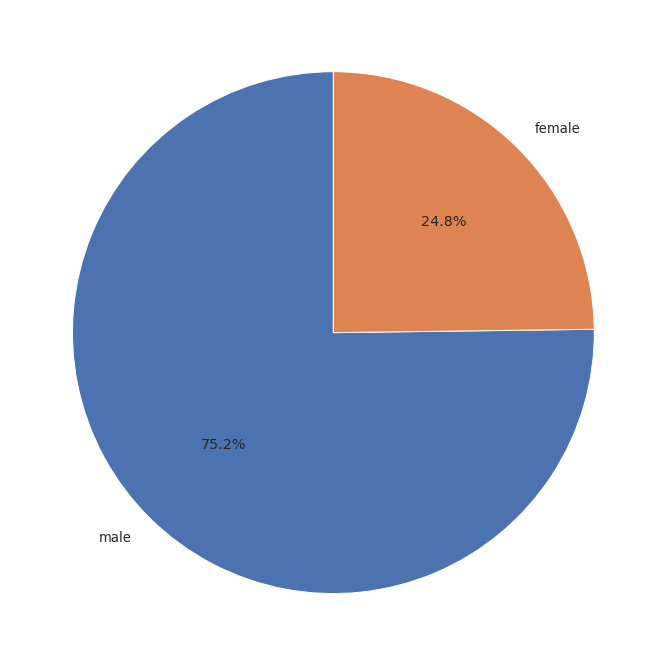

In [246]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.pie(train['gender'].value_counts(), labels=train['gender'].value_counts().index, autopct='%1.1f%%',
        shadow=False, startangle=90)
plt.show()